In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import lib.features as features
import lib.breeds as breeds
import lib.plots as plots
import lib.models as models

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
data_folder = '../data/csv/'
data_files = [mice + ".smo.csv" for mice in breeds.mice_breeds["c57bl6"]][:]
data_files_train = data_files[:-1] #TODO change [:1] to [:-1] to train on all instead of one
data_files_test = data_files[-1:]

print(f"Training on {data_files_train}")
print(f"Testing on {data_files_test}")

days = [0]#, 1, 2, 3]
window_sizes = []#[2, 5, 10, 20, 50, 100]
window_features = ["EEGv", "EMGv"]
spectral=False # TODO: True
rolloffs = []#[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
test_size = 0.3
useRaw = False
dropBins = True
cat_matrix = True # True for neural net, any for random forest
standardize_df = False

lr=1e-4
epochs=150
batch_size=64

seed = 13

Training on ['BL601.smo.csv', 'BL602.smo.csv', 'BL606.smo.csv', 'BL609.smo.csv', 'BL610.smo.csv', 'BL611.smo.csv', 'BL612.smo.csv', 'BL614.smo.csv', 'BL616.smo.csv', 'BL6V1.smo.csv', 'BL6V2.smo.csv']
Testing on ['BL6V3.smo.csv']


In [3]:
# train and test on same mice
df_train = features.clean_data(
    data_folder=data_folder, 
    data_files=data_files_train,
    days=days, 
    window_sizes=window_sizes, 
    window_features=window_features,
    spectral=spectral,
    rolloffs=rolloffs,
    dropBins=dropBins, 
    useRaw=useRaw, 
    balance=True, 
    standardize_df=standardize_df,
    seed=seed,
)

df_test = features.clean_data(
    data_folder=data_folder, 
    data_files=data_files_test,
    days=days, 
    window_sizes=window_sizes, 
    window_features=window_features,
    spectral=spectral,
    rolloffs=rolloffs,
    dropBins=dropBins, 
    useRaw=useRaw, 
    balance=False, 
    standardize_df=standardize_df,
    seed=seed,
)

x_train, x_test, y_train, y_test, le = features.encode_scale_data(df_train=df_train, df_test=df_test, useRaw=useRaw, seed=seed, cat_matrix=cat_matrix)

# Neural Network

In [4]:
model = models.nn_baseline_model(x_train.shape[1], le.classes_.size, lr=lr)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 30        
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

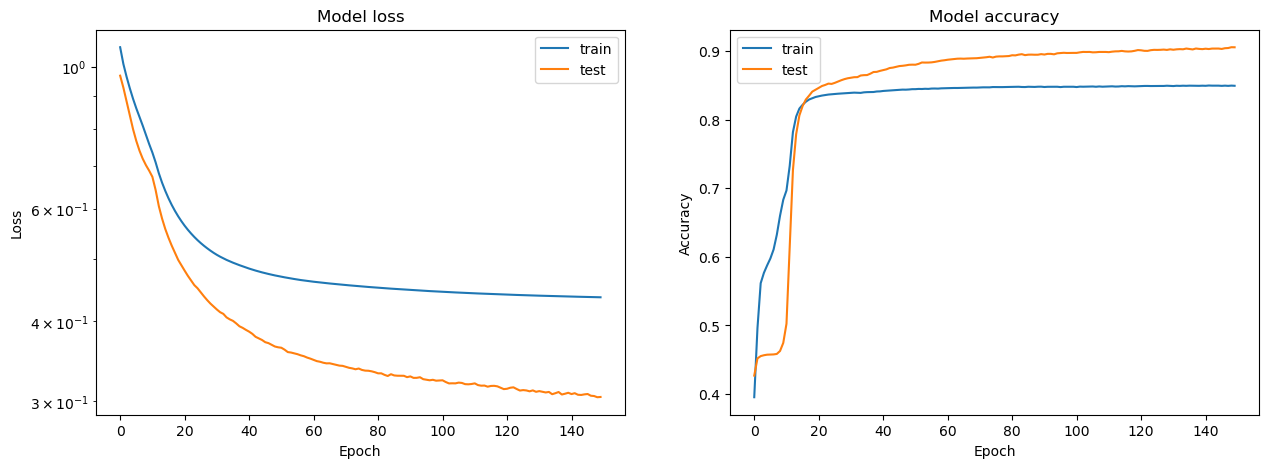

In [5]:
model = models.nn_baseline_model(x_train.shape[1], le.classes_.size, lr=lr)
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

plots.plot_history(history.history)

662/662 [==============================] - 1s 776us/step
[[8616  282   45]
 [  75 1049    7]
 [ 385 1207 9504]]
              precision    recall  f1-score   support

           n       0.95      0.96      0.96      8943
           r       0.41      0.93      0.57      1131
           w       0.99      0.86      0.92     11096

    accuracy                           0.91     21170
   macro avg       0.79      0.92      0.82     21170
weighted avg       0.94      0.91      0.92     21170



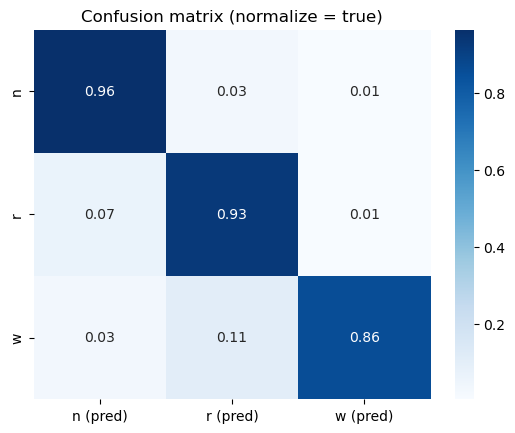

In [6]:
plots.plot_confusion(model=model, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')

# Random Forest

[[8463  437   43]
 [ 279  826   26]
 [ 533 1366 9197]]
              precision    recall  f1-score   support

           n       0.91      0.95      0.93      8943
           r       0.31      0.73      0.44      1131
           w       0.99      0.83      0.90     11096

    accuracy                           0.87     21170
   macro avg       0.74      0.84      0.76     21170
weighted avg       0.92      0.87      0.89     21170



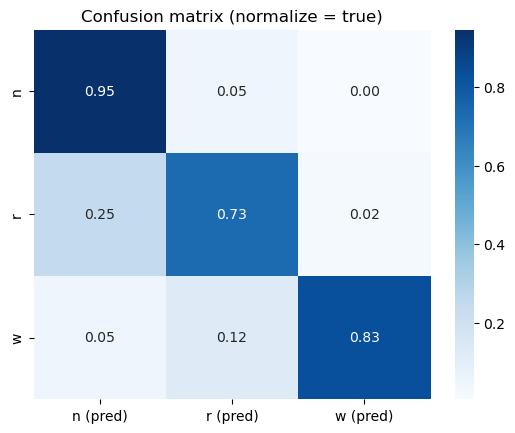

In [7]:
rfc = RandomForestClassifier(random_state=seed)
rfc.fit(x_train, y_train)
y_predict = rfc.predict(x_test)
plots.plot_confusion(model=rfc, x_test=x_test, y_test=y_test, le=le, cat_matrix=cat_matrix, normalize='true')